In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk

from scipy import optimize
from scipy.signal import find_peaks
from astropy.stats import LombScargle

from matplotlib import rcParams
rcParams["figure.dpi"] = 150

from lmfit import Model

import scipy.special
import math

from astropy.io import fits

import random

from astropy.time import Time

import os

from scipy.ndimage import gaussian_filter
from astropy.stats import sigma_clip

In [16]:
import matplotlib

In [2]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 150

SearchResult containing 4 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
  270577175 tess2018292075959-s0004-0000000270577175-0124-s_lc.fits Light curves      0.0
  270577175 tess2018319095959-s0005-0000000270577175-0125-s_lc.fits Light curves      0.0
  270577175 tess2018349182459-s0006-0000000270577175-0126-s_lc.fits Light curves      0.0
  270577175 tess2019006130736-s0007-0000000270577175-0131-s_lc.fits Light curves      0.0


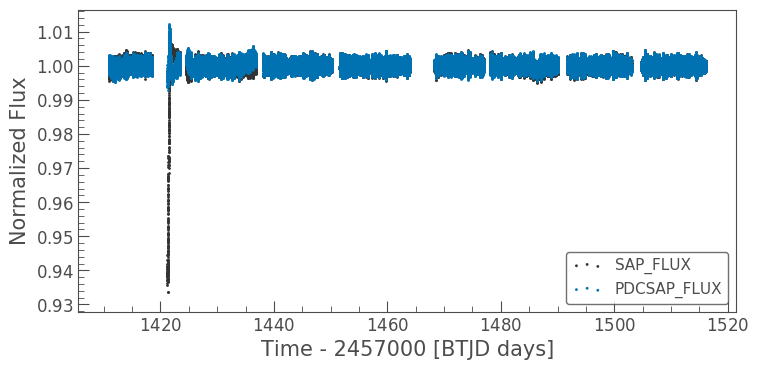

In [5]:
for name in ['beta Pictoris']:
    sr = lk.search_lightcurvefile(name)
    print(sr)

    if len(sr) > 0:

        #Download data
        lcfs = sr.download_all()

        # Use the normalized PDCSAP_FLUX
        lc0 = lcfs[0].SAP_FLUX.normalize()
        lc1 = lcfs[0].PDCSAP_FLUX.normalize()

        # Loop through the rest of the LCFS, appending to the first light curve
        for lcf in lcfs[1:]:
            lc0 = lc0.append(lcf.SAP_FLUX.normalize())
            lc1 = lc1.append(lcf.PDCSAP_FLUX.normalize())

        #Remove bad quality and nans
        q0 = lc0.quality == 0
        lc0 = lc0[q0].remove_nans()
        q1 = lc1.quality == 0
        lc1 = lc1[q1].remove_nans()
        #Plot data
        ax = lc0.scatter(label = 'SAP_FLUX')
        lc1.scatter(ax=ax, label = 'PDCSAP_FLUX')

        
        #Times & Mags
        times = lc1.time + 2457000
        mags = -2.5 * np.log10(lc1.flux)
        mags = mags - np.median(mags)
        
        x = times
        y = mags

In [8]:
#Amplitude Spectrum Function
def AS(times, flux, oversample):
    timebase = max(times) - min(times)
    tmin = min(times)
    tmax = max(times)
    df = 1.0 / (tmax - tmin)
    dt = np.median(np.diff(times))
    ny = 0.5 / dt
    oversample = oversample

    freq = np.arange(df, 120, df / oversample)
    model = LombScargle(times, flux)
    power = model.power(freq, method = 'fast', normalization = 'psd')
    fct = np.sqrt(4 / len(times))
    amp = np.sqrt(np.abs(power)) * fct
    
    return((freq, amp))

In [9]:
#Fourier Function
def fourier_sum(freqs, amps, phase, y_noise, x):
    y = []
    for j in range(0, len(x)):
        temp = []
        temp.append(y_noise[j])
        for i in range(0, len(freqs)):
            #next line: sum(amplitude_i * sine(freq_i * x + phase_i)) for all pulsations i 
            temp.append(amps[i]*np.sin(2.*np.pi*freqs[i]*x[j]+phase[i]))
        y.append(sum(temp))
    return y

def lc_sim(freqs, amps, phs, time_start, time_end, cadence, precision):
    freqs = np.array(freqs)
    amps = np.array(amps)
    phs = np.array(phs)
    
    time = np.arange(time_start, time_end, cadence)
    noise = np.random.normal(0, precision, len(time))
    
    multisine = np.array(fourier_sum(freqs, amps, phs, noise, time))

    return [freqs, amps, phs, time, multisine]

def lc_model(freqs, amps, phs, time_start, time_end, cadence_model):
    freqs = np.array(freqs)
    amps = np.array(amps)
    phs = np.array(phs)
    
    time_model = np.arange(time_start, time_end, cadence_model)
    noise_model = [0 for i in time_model]    

    multisine_model = np.array(fourier_sum(freqs, amps, phs, noise_model, time_model))

    return [freqs, amps, phs, time_model, multisine_model]

def lc_model_times(freqs, amps, phs, times):
    freqs = np.array(freqs)
    amps = np.array(amps)
    phs = np.array(phs)
    
    time_model = times
    noise_model = [0 for i in time_model]  

    multisine_model = np.array(fourier_sum(freqs, amps, phs, noise_model, time_model))

    return [freqs, amps, phs, time_model, multisine_model]

def lc_model_times(freqs, amps, phs, times, precision):
    freqs = np.array(freqs)
    amps = np.array(amps)
    phs = np.array(phs)
    
    time_model = times
    noise_model = np.random.normal(0, precision, len(time_model))
    #noise_model = [0 for i in time_model]  

    multisine_model = np.array(fourier_sum(freqs, amps, phs, noise_model, time_model))

    return [freqs, amps, phs, time_model, multisine_model]

In [10]:
def dft_phase(x, y, freq):
    """ 
    Discrete fourier transform to calculate the ASTC phase
    given x, y, and an array of frequencies
    
    Parameters
    ----------
        x : `array`
            Array in which to calculate 
        x : `array`
    
    Returns:
    ----------
        phase : `list`
            A list of phases for the given frequencies
    """

    freq = np.asarray(freq)
    x = np.array(x)
    y = np.array(y)
    phase = []
    for f in freq:
        expo = 2.0 * np.pi * f * x
        ft_real = np.sum(y * np.cos(expo))
        ft_imag = np.sum(y * np.sin(expo))
        phase.append(np.arctan2(ft_imag,ft_real))
        
        
    ## my phase wrapping patch
    tmp = []
    for i in phase:
        if i < 0:
            tmp.append(i + 2 * np.pi)
        else:
            tmp.append(i)

    p = np.array(tmp)
    p = (- p + np.pi/2) % (2 * np.pi)

    return p

In [12]:
#Expected units:
#t ... Time in days
#a1sini ... in seconds
#Porb ... in days
#star_planet_ratio ... how many times heavier is the star?

def tau(t, star_planet_ratio, a2sini , e, varpi, Porb, tp, nobessel):
    
    Omega = 2 * np.pi / Porb
    
    term1 = -a2sini / star_planet_ratio * 499 / 86400
    term2 = (1-e**2)
    
    sum_cosf = sum(scipy.special.jv(n,n*e)*np.cos(n*Omega*(t-tp)) for n in range(1,nobessel))
    sum_sinf = sum(scipy.special.jvp(n,n*e,n=1)*np.sin(n*Omega*(t-tp)) for n in range(1,nobessel))
    
    
    cosf  = - e + 2*(1-e**2)/e * sum_cosf
    sinf  = 2 * math.sqrt(1 - e**2) * sum_sinf
    
    term3 = (sinf * np.cos(varpi) + cosf * np.sin(varpi))/(1. + e*cosf)
    
    sol = term1*term2*term3
    
    return sol

def vrad(t, star_planet_ratio, a2sini , e, varpi, Porb, tp, nobessel):
    
    Omega = 2 * np.pi / Porb
    
    term1 = - Omega * a2sini / star_planet_ratio *1.736*10**6 #num.value is AU/day into m/s
    term2 = math.sqrt(1-e**2)
    
    sum_cosf = sum(scipy.special.jv(n,n*e)*np.cos(n*Omega*(t-tp)) for n in range(1,nobessel))
    sum_sinf = sum(scipy.special.jvp(n,n*e,n=1)*np.sin(n*Omega*(t-tp)) for n in range(1,nobessel))
    
    
    cosf  = - e + 2*(1-e**2)/e * sum_cosf
    sinf  = 2 * math.sqrt(1 - e**2) * sum_sinf
    
    term3 = (cosf * np.cos(varpi) - sinf * np.sin(varpi)) + e * np.cos(varpi)
    
    sol = term1*term2*term3
    
    return sol

In [14]:
#https://stackoverflow.com/questions/14581358/getting-standard-errors-on-fitted-parameters-using-the-optimize-leastsq-method-i
def fit_leastsq_my(times, mags, freqs, amps, phs):
    
    pfit_all = []
    perr_all = []
    
    for i in range(len(freqs)):

        def model_new(freq):
            def f(x, p1, p2):
                return abs(p1) * np.sin(2. * np.pi * (freq * x + (p2)%1))
            return f
        
        def ff(x, p):
            return model_new(freqs[i])(x, *p)
        
        # These are initial guesses for fits:
        pstart = [amps[i], phs[i]]
    
        def fit_leastsq(p0, datax, datay, function):

            errfunc = lambda p, x, y: function(x,p) - y

            pfit, pcov, infodict, errmsg, success = optimize.leastsq(errfunc, p0, args=(datax, datay), full_output=1, epsfcn=0.0001)

            if (len(datay) > len(p0)) and pcov is not None:
                s_sq = (errfunc(pfit, datax, datay)**2).sum()/(len(datay)-len(p0))
                pcov = pcov * s_sq
            else:
                pcov = np.inf

            error = [] 
            for i in range(len(pfit)):
                try:
                    error.append(np.absolute(pcov[i][i])**0.5)
                except:
                    error.append( 0.00 )
            pfit_leastsq = pfit
            perr_leastsq = np.array(error) 
            return pfit_leastsq, perr_leastsq 

        pfit, perr = fit_leastsq(pstart, times, mags, ff)
        pfit_all.append(pfit)
        perr_all.append(perr)
        
    my_amps = np.array([pfit_all[i][0] for i in range(len(freqs))])
    my_phs = np.array([pfit_all[i][1] for i in range(len(freqs))])
    my_phs_err = np.array([perr_all[i][1] for i in range(len(freqs))])
    
    return(freqs, my_amps, my_phs, my_phs_err)

In [18]:
def rms2(array):
    array = np.array(array)
    tmp = np.sqrt(np.mean((array)**2))
    return tmp

DEFINE AS FUNTION
CALCULATE FREQS OF BETA PIC
IMPORT KEPLER TIMESTAMPS
61.17409022396696
778
CREATE MULTISINE MODEL
CALCULATE TIME DELAYS (MODEL)
CALCULATE TIME DELAYS (DATA)
DOWNLOAD JDs
CALCULATE WEIGHTED VALUES
PLOT EVERYTHING


/home/sebastian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


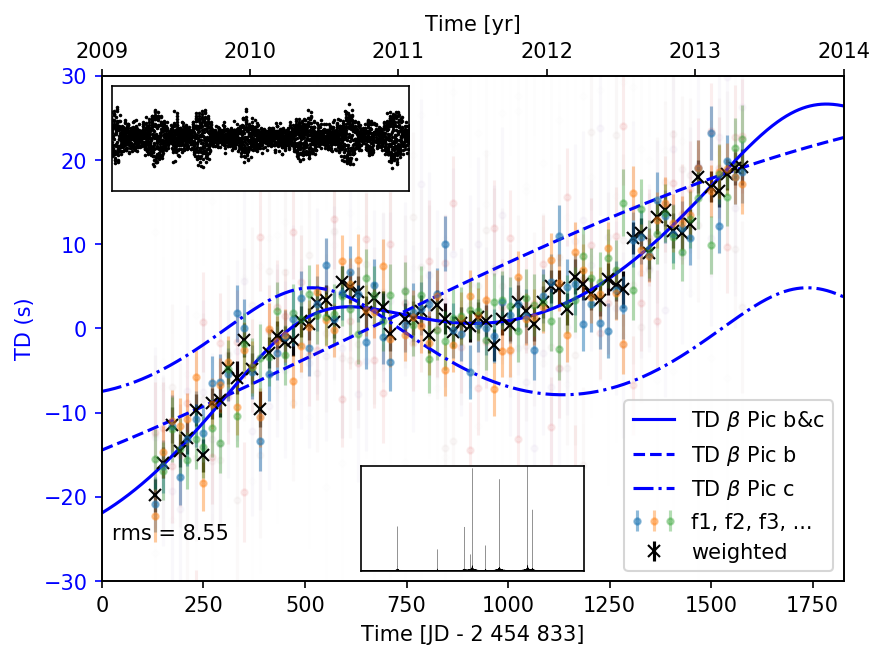

In [56]:
no_freqs_run = 9
no_freqs_run_weighted = 3
noise_TESS_mag_hour_ppm = 5*19.91
noise_hour_ppm = noise_TESS_mag_hour_ppm
segment_size = 20


# print('DOWNLOAD DATA')
# for name in ['beta Pictoris']:
#     sr = lk.search_lightcurvefile(name)
#     print(sr)

#     if len(sr) > 0:

#         #Download data
#         lcfs = sr.download_all()

#         # Use the normalized PDCSAP_FLUX
#         lc0 = lcfs[0].SAP_FLUX.normalize()
#         lc1 = lcfs[0].PDCSAP_FLUX.normalize()

#         # Loop through the rest of the LCFS, appending to the first light curve
#         for lcf in lcfs[1:]:
#             lc0 = lc0.append(lcf.SAP_FLUX.normalize())
#             lc1 = lc1.append(lcf.PDCSAP_FLUX.normalize())

#         #Remove bad quality and nans
#         q0 = lc0.quality == 0
#         lc0 = lc0[q0].remove_nans()
#         q1 = lc1.quality == 0
#         lc1 = lc1[q1].remove_nans()
#         #Plot data
#         ax = lc0.scatter(label = 'SAP_FLUX')
#         lc1.scatter(ax=ax, label = 'PDCSAP_FLUX')

        
#         #Times & Mags
#         times = lc1.time + 2457000
#         mags = -2.5 * np.log10(lc1.flux)
#         mags = mags - np.median(mags)
        
#         x = times
#         y = mags

        
print('DEFINE AS FUNTION')
#Amplitude Spectrum Function
def AS(times, flux, oversample):
    timebase = max(times) - min(times)
    tmin = min(times)
    tmax = max(times)
    df = 1.0 / (tmax - tmin)
    dt = np.median(np.diff(times))
    ny = 0.5 / dt
    oversample = oversample

    freq = np.arange(df, 120, df / oversample)
    model = LombScargle(times, flux)
    power = model.power(freq, method = 'fast', normalization = 'psd')
    fct = np.sqrt(4 / len(times))
    amp = np.sqrt(np.abs(power)) * fct
    
    return((freq, amp))


print('CALCULATE FREQS OF BETA PIC')

#AS
freq, amp = AS(times, mags, 15)
freq=freq[5000:]
amp=amp[5000:]

# PEAKS
max_power = amp.max()
peaks, _ = find_peaks(amp, height=max_power*0.02, distance=200)

# FREQS SORTED BY AMPLITUDE
sort_idx = np.argsort(amp[peaks])[::-1]
f_TESS = freq[peaks][sort_idx]
a_TESS = amp[peaks][sort_idx]
#print(len(f_TESS))



print('IMPORT KEPLER TIMESTAMPS')
import os
datadir = os.getcwd()
datafile = '/times_KIC.txt'

times_KIC_load = np.loadtxt(datadir+datafile, usecols=(0)).T
times_KIC = times_KIC_load


cadence_hour = 1/(np.median(np.diff(times_KIC))*24) # Measurements in 1 hour
print(cadence_hour)
noise_run = noise_hour_ppm * 1e-6 * np.sqrt(cadence_hour)
noise_run_ppm = int(noise_run*1e6)
print(noise_run_ppm)







#times_KIC = midvals(times_KIC)
#times_KIC = times_KIC[times_KIC % 1 > 0.5]

print('CREATE MULTISINE MODEL')

#Phases
f_TESS = f_TESS[:no_freqs_run]
a_TESS = a_TESS[:no_freqs_run]
p_TESS = dft_phase(times, mags, f_TESS)/(2*np.pi)

model_times = lc_model_times(f_TESS, a_TESS, p_TESS*2*np.pi, times_KIC, noise_run)





print('CALCULATE TIME DELAYS (MODEL)')
#_b
star_planet_ratio_b = 1.8 / 11 * 1048
a2sini_b = 9.66 * np.sin(np.deg2rad(88.81))
e_b = 0.08
varpi_b = np.deg2rad(205.8)
Porb_b = 22.47*365.25
tp_b = 2455992

#_c
star_planet_ratio_c = 1.8 / 8.9 * 1048
a2sini_c = 2.7 * np.sin(np.deg2rad(88.81))
e_c = 0.24
varpi_c = np.deg2rad(-95)
Porb_c = 1220
tp_c = 2454117

y_tau_b = tau(times_KIC, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
#y_vrad_b = vrad(times_KIC, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c = tau(times_KIC, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
#y_vrad_c = vrad(times_KIC, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)



print('CALCULATE TIME DELAYS (DATA)')


times_TD = times_KIC - y_tau_b - y_tau_c
magnitudes_TD = model_times[4]



time_0 = times_TD[0]
time_slice, mag_slice, phase, phase_err = [], [], [], []
time_delays, time_delays_err, time_midpoints = [], [], []

t_edge = []

counter = 1
size=int((max(times_TD)-min(times_TD))//segment_size)

# Iterate over lightcurve
for t, y in zip(times_TD, magnitudes_TD):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if t - time_0 > segment_size:
        #print('{0}/{1}'.format(counter, size))
        # Append the time midpoint
        
        time_slice = np.array(time_slice)
        mag_slice = np.array(mag_slice)
        
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        
        phase_guess = dft_phase(time_slice, mag_slice, f_TESS)
        sol = fit_leastsq_my(time_slice, mag_slice, f_TESS, a_TESS, phase_guess/(2*np.pi))
        
        #print(phase_guess)
        phase.append(phase_guess)
        phase_err.append(sol[3]*2*np.pi)
        
        time_0 = t
        time_slice, mag_slice = [], []

        t_edge.append(t)
        
        counter += 1
        
phase = np.array(phase).T
phase_err = np.array(phase_err).T

# Phase wrapping patch
for ph, ph_err, f in zip(phase, phase_err, f_TESS):
    td = ph / (2*np.pi*f)
    time_delays.append(td-np.mean(td))
    time_delays_err.append(ph_err / (2*np.pi*f))
    


print('DOWNLOAD JDs')
jds = []
for i in np.arange(2009, 2015, 1):
    times_utc = ['{0}-01-01T12:00:00'.format(i)]
    t = Time(times_utc, format='isot', scale='utc')
    #print(t)
    #print(t.jd)
    jds.append(t.jd[0])



print('CALCULATE WEIGHTED VALUES')

time_delays_tmp = time_delays[:no_freqs_run_weighted]
time_delays_err_tmp = time_delays_err[:no_freqs_run_weighted]

td_weighted = []
td_weighted_err = []
for i in range(len(time_midpoints)):
    #print(i)
    tds, tds_err = [], []
    for j in range(len(time_delays_tmp)):
        #print(j)
        tds.append(time_delays_tmp[j][i])
        tds_err.append(time_delays_err_tmp[j][i])
    tds = np.array(tds)
    tds_err = np.array(tds_err)
    td_weighted.append(sum(tds/tds_err**2)/sum(1/tds_err**2))
    td_weighted_err.append((1/sum(1/tds_err**2))**(1/2))
td_weighted = np.array(td_weighted)
td_weighted_err = np.array(td_weighted_err)

print('PLOT EVERYTHING')
times_sim = np.linspace(jds[0], jds[-1], 1000)

y_tau_b_sim = tau(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
#y_vrad_b_sim = vrad(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim = tau(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
#y_vrad_c_sim = vrad(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

fig, ax1 = plt.subplots(1,1, figsize=(6, 4.5))

time_offset = 2454833

t_2009 = jds[0] - time_offset
t_2010 = jds[1] - time_offset
t_2011 = jds[2] - time_offset
t_2012 = jds[3] - time_offset
t_2013 = jds[4] - time_offset
t_2014 = jds[5] - time_offset


#ax1.set_xlim(jds[0] - time_offset, jds[-1] - time_offset)
lns11 = ax1.plot(times_sim - time_offset, (y_tau_b_sim + y_tau_c_sim) *86400, 'b', label = r"TD $\beta$ Pic b&c")
lns12 = ax1.plot(times_sim - time_offset, (y_tau_b_sim) *86400, 'b', ls = '--', label = r"TD $\beta$ Pic b")
lns13 = ax1.plot(times_sim - time_offset, (y_tau_c_sim) *86400, 'b', ls = '-.', label = r"TD $\beta$ Pic c")
ax1.set_xlabel('Time [JD - 2 454 833]')

ax1.set_ylabel('TD (s)', color='b')
ax1.tick_params('y', colors='b')
ax1.set_ylim(-30, 30)
ax1.set_xlim(t_2009, t_2014)

#ax2 = ax1.twinx()
# lns2 = ax2.plot(times_sim - time_offset, y_vrad_b + y_vrad_c, 'r', label = "RV curve")
# ax2.plot(times_sim - time_offset, y_vrad_b , 'r', label = "RV curve", ls = '--')
# ax2.plot(times_sim - time_offset, y_vrad_c, 'r', label = "RV curve", ls = '-.')
# ax2.set_ylabel('v$_{rad}$ (m/s)', color='r')
# ax2.tick_params('y', colors='r')

#lns = lns1+lns2
#labs = [l.get_label() for l in lns]


ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)

ax2.set_xticks([t_2009,t_2010,t_2011,t_2012,t_2013,t_2014])

#ax1.set_xlim(1070,1090)
#ax1.set_ylim(-120,70)

xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)
ax2.set_xticklabels(['2009', '2010', '2011', '2012', '2013', '2014'], fontsize=10)


ax2.set_xlabel('Time [yr]', labelpad=-200)
ax2.xaxis.set_label_coords(0.5,1.09)


#ax1.set_xlabel('BJD - 2457000.0 [d]')
#ax1.set_ylabel('magnitudes [mmag]')

#ttl = ax1.title
#ttl.set_position([.5, 1.05])

#ax1.set_title('bRing+BLb')


#lns3 = ax1.axvspan(min(times_KIC) - time_offset, max(times_KIC) - time_offset, alpha=0.5,  label='TESS')
# lns4 = ax1.axvspan(min(tB15_BJD) - time_offset, max(tB15_BJD) - time_offset, alpha=0.35, color='darkgreen', label='BRITE')
# ax1.axvspan(min(tB16_BJD) - time_offset, max(tB16_BJD) - time_offset, alpha=0.35, color='darkgreen')
# ax1.axvspan(min(tB17_BJD) - time_offset, max(tB17_BJD) - time_offset, alpha=0.35, color='darkgreen')
# lns5 = ax1.axvspan(min(t_bRing) - time_offset, max(t_bRing) - time_offset, alpha=0.5, color='k', label='bRing')
# lns6 = ax1.axvspan(min(t_ASTEP) - time_offset, 2458011.168025- time_offset, alpha=0.35, color='red', label='ASTEP')
# ax1.axvspan(2458206.1510377- time_offset, max(t_ASTEP) - time_offset, alpha=0.35, color='red')


y_tau_b_sim = tau(np.array(time_midpoints), star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim = tau(np.array(time_midpoints), star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
y_offset = np.median((y_tau_b_sim + y_tau_c_sim) *86400 - td_weighted*86400)
#ax1.scatter(np.array(time_midpoints) - time_offset, td_weighted*86400+y_offset, marker='x', c='k')   
lns2 = ax1.errorbar(np.array(time_midpoints) - time_offset, td_weighted*86400+y_offset, yerr = td_weighted_err*86400, fmt='.', marker='x', c='k', label = 'weighted')

leg_errbar = []
for i in range(no_freqs_run):
    #ax1.scatter(time_midpoints, time_delays[i]*86400, s=5)
    lns3 = ax1.errorbar(np.array(time_midpoints) - time_offset, time_delays[i]*86400+y_offset, yerr = time_delays_err[i]*86400, fmt='.', alpha = ((a_TESS[i]/a_TESS[0])**3)/2)
    ax1.set_ylim(-30, 30)
    leg_errbar.append(lns3)

from mpl_toolkits.axes_grid.inset_locator import inset_axes
inset_axes1 = inset_axes(ax1, 
                    width="40%", # width = 30% of parent_bbox
                    height=0.7, # height : 1 inch
                    loc=2)
plt.scatter(times_TD, magnitudes_TD, s=0.5, c='k')
plt.xlim(min(times_TD)+1, min(times_TD)+3)
#plt.title('One day zoom')
#plt.xticks([min(times_TD)+1, min(times_TD)+3])
#plt.yticks([min(magnitudes_TD), 0, max(magnitudes_TD)])
plt.xticks([])
plt.yticks([])

inset_axes2 = inset_axes(ax1, 
                    width="30%", # width = 30% of parent_bbox
                    height=0.7, # height : 1 inch
                    loc=8)
plt.plot(AS(times_TD, magnitudes_TD, 2)[0], AS(times_TD, magnitudes_TD, 2)[1]*1e6, lw=0.1, c='k')
plt.xlim(35, 60)
plt.ylim(0, max(AS(times_TD, magnitudes_TD, 2)[1])*1e6)
#plt.title('AS')
#plt.xticks([35, 60])
#plt.yticks([0, max(AS(times_TD, magnitudes_TD, 2)[1])*1e6])
plt.xticks([])
plt.yticks([])



# lns = [lns1[0], lns2[0], lns4, lns5, lns6, lns3]
# labs = [l.get_label() for l in lns]

#ax1.legend()
#ax1.legend(lns, labs, loc=4)

lns = [lns11[0], lns12[0], lns13[0], lns2]#lns2[0], lns4, lns5, lns6, lns3]
labs = [l.get_label() for l in lns]

#https://stackoverflow.com/questions/52038171/how-to-create-two-legend-objects-for-a-single-plot-instance/52040748#52040748
ax1.legend(handles = lns[:3]+[tuple(leg_errbar[:3])]+lns[3:], labels=labs[:3]+['f1, f2, f3, ...']+labs[3:],loc=4,
               handler_map = {tuple: matplotlib.legend_handler.HandlerTuple(None)})


# textstr = '\n'.join((
#     'rms b=%.1f' % (rms2(y_tau_b_sim*86400-(td_weighted*86400+y_offset)), ),
#     'rms b+c=%.1f' % (rms2((y_tau_b_sim+y_tau_c_sim)*86400- (td_weighted*86400+y_offset)), )))
# ax1.text(0.02, 0.1, textstr, transform=ax.transAxes, fontsize=8,
#         verticalalignment='top')

ax1.text(25, -25,'rms = {0:.2f}'.format(rms2(td_weighted*86400+y_offset)))
         
fig.tight_layout()
plt.show()

fig.savefig("TD_Kepler-Seg{0}-NoF{1}-NoFw{2}-Noisehr{3}-len{4}.png".format(segment_size, no_freqs_run, no_freqs_run_weighted, noise_hour_ppm, len(times_TD)), dpi=400)

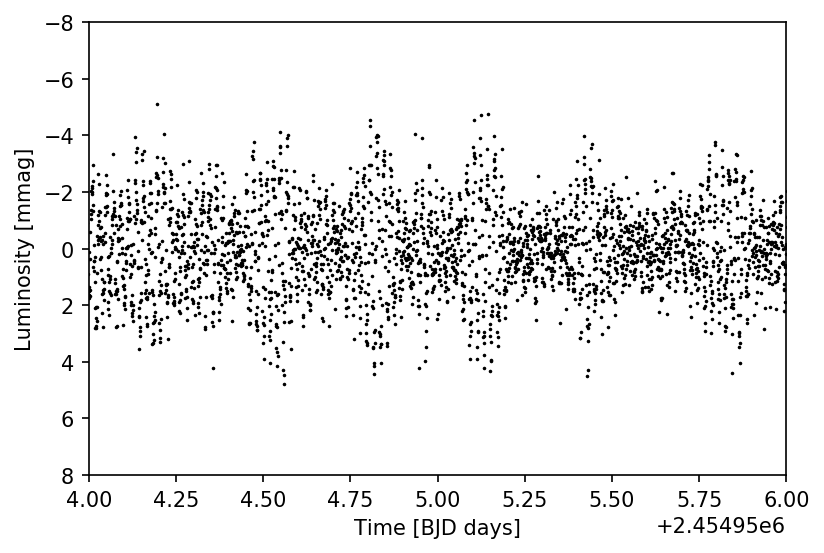

In [59]:
plt.scatter(times_TD, magnitudes_TD*1000, s=0.5, c='k')
#plt.xlim(min(times_TD), min(times_TD)+2)
plt.xlim(2454954, 2454954+2)
#plt.title('One day zoom')
#plt.xticks([min(times_TD)+1, min(times_TD)+3])
#plt.yticks([min(magnitudes_TD), 0, max(magnitudes_TD)])
#plt.xticks([])
#plt.yticks([])
plt.xlabel('Time [BJD days]')
plt.ylabel('Luminosity [mmag]')

plt.ylim(8, -8)

plt.savefig('lc1.png')

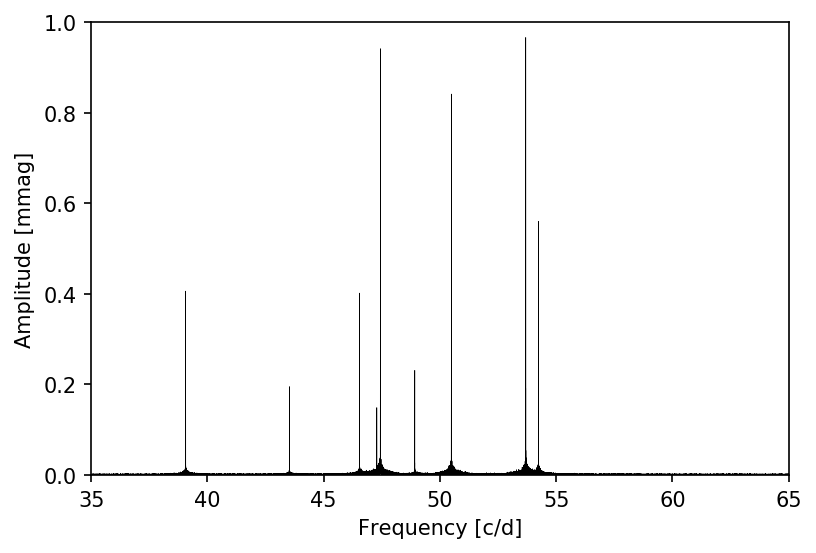

In [60]:
plt.plot(AS(times_TD, magnitudes_TD, 2)[0], AS(times_TD, magnitudes_TD, 2)[1]*1e3, lw=0.3, c='k')
plt.xlim(35, 65)
plt.ylim(0, 1)#max(AS(times_TD, magnitudes_TD, 2)[1])*1e6)
#plt.title('AS')
#plt.xticks([35, 60])
#plt.yticks([0, max(AS(times_TD, magnitudes_TD, 2)[1])*1e6])
#plt.xticks([])
#plt.yticks([])
plt.xlabel('Frequency [c/d]')
plt.ylabel('Amplitude [mmag]')

plt.savefig('as1.png')

In [61]:
def midvals(array):
    array = np.array(array)
    if len(array)%2 == 0:
        tmp = (array[::2]+array[1::2])/2
    elif len(array)%2 == 1:
        tmp = (array[::2][:-1]+array[1::2])/2
    return tmp

DEFINE AS FUNTION
CALCULATE FREQS OF BETA PIC
IMPORT KEPLER TIMESTAMPS
61.17409022396696
778
CREATE MULTISINE MODEL
CALCULATE TIME DELAYS (MODEL)
CALCULATE TIME DELAYS (DATA)
DOWNLOAD JDs
CALCULATE WEIGHTED VALUES
PLOT EVERYTHING


/home/sebastian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


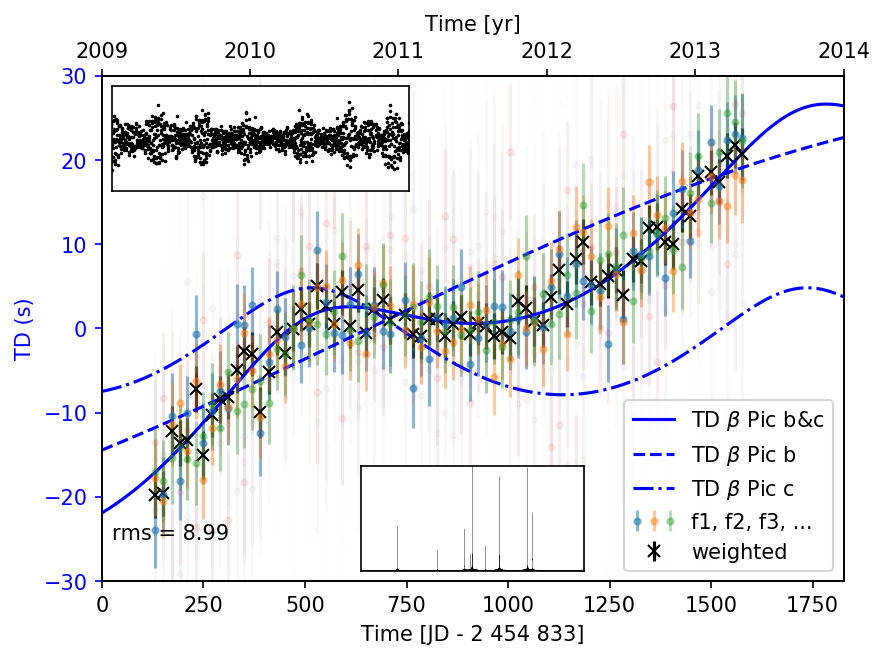

In [62]:
no_freqs_run = 9
no_freqs_run_weighted = 3
noise_TESS_mag_hour_ppm = 5*19.91
noise_hour_ppm = noise_TESS_mag_hour_ppm
segment_size = 20


# print('DOWNLOAD DATA')
# for name in ['beta Pictoris']:
#     sr = lk.search_lightcurvefile(name)
#     print(sr)

#     if len(sr) > 0:

#         #Download data
#         lcfs = sr.download_all()

#         # Use the normalized PDCSAP_FLUX
#         lc0 = lcfs[0].SAP_FLUX.normalize()
#         lc1 = lcfs[0].PDCSAP_FLUX.normalize()

#         # Loop through the rest of the LCFS, appending to the first light curve
#         for lcf in lcfs[1:]:
#             lc0 = lc0.append(lcf.SAP_FLUX.normalize())
#             lc1 = lc1.append(lcf.PDCSAP_FLUX.normalize())

#         #Remove bad quality and nans
#         q0 = lc0.quality == 0
#         lc0 = lc0[q0].remove_nans()
#         q1 = lc1.quality == 0
#         lc1 = lc1[q1].remove_nans()
#         #Plot data
#         ax = lc0.scatter(label = 'SAP_FLUX')
#         lc1.scatter(ax=ax, label = 'PDCSAP_FLUX')

        
#         #Times & Mags
#         times = lc1.time + 2457000
#         mags = -2.5 * np.log10(lc1.flux)
#         mags = mags - np.median(mags)
        
#         x = times
#         y = mags

        
print('DEFINE AS FUNTION')
#Amplitude Spectrum Function
def AS(times, flux, oversample):
    timebase = max(times) - min(times)
    tmin = min(times)
    tmax = max(times)
    df = 1.0 / (tmax - tmin)
    dt = np.median(np.diff(times))
    ny = 0.5 / dt
    oversample = oversample

    freq = np.arange(df, 120, df / oversample)
    model = LombScargle(times, flux)
    power = model.power(freq, method = 'fast', normalization = 'psd')
    fct = np.sqrt(4 / len(times))
    amp = np.sqrt(np.abs(power)) * fct
    
    return((freq, amp))


print('CALCULATE FREQS OF BETA PIC')

#AS
freq, amp = AS(times, mags, 15)
freq=freq[5000:]
amp=amp[5000:]

# PEAKS
max_power = amp.max()
peaks, _ = find_peaks(amp, height=max_power*0.02, distance=200)

# FREQS SORTED BY AMPLITUDE
sort_idx = np.argsort(amp[peaks])[::-1]
f_TESS = freq[peaks][sort_idx]
a_TESS = amp[peaks][sort_idx]
#print(len(f_TESS))



print('IMPORT KEPLER TIMESTAMPS')
import os
datadir = os.getcwd()
datafile = '/times_KIC.txt'

times_KIC_load = np.loadtxt(datadir+datafile, usecols=(0)).T
times_KIC = times_KIC_load


cadence_hour = 1/(np.median(np.diff(times_KIC))*24) # Measurements in 1 hour
print(cadence_hour)
noise_run = noise_hour_ppm * 1e-6 * np.sqrt(cadence_hour)
noise_run_ppm = int(noise_run*1e6)
print(noise_run_ppm)







times_KIC = midvals(times_KIC)
#times_KIC = times_KIC[times_KIC % 1 > 0.5]

print('CREATE MULTISINE MODEL')

#Phases
f_TESS = f_TESS[:no_freqs_run]
a_TESS = a_TESS[:no_freqs_run]
p_TESS = dft_phase(times, mags, f_TESS)/(2*np.pi)

model_times = lc_model_times(f_TESS, a_TESS, p_TESS*2*np.pi, times_KIC, noise_run)





print('CALCULATE TIME DELAYS (MODEL)')
#_b
star_planet_ratio_b = 1.8 / 11 * 1048
a2sini_b = 9.66 * np.sin(np.deg2rad(88.81))
e_b = 0.08
varpi_b = np.deg2rad(205.8)
Porb_b = 22.47*365.25
tp_b = 2455992

#_c
star_planet_ratio_c = 1.8 / 8.9 * 1048
a2sini_c = 2.7 * np.sin(np.deg2rad(88.81))
e_c = 0.24
varpi_c = np.deg2rad(-95)
Porb_c = 1220
tp_c = 2454117

y_tau_b = tau(times_KIC, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
#y_vrad_b = vrad(times_KIC, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c = tau(times_KIC, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
#y_vrad_c = vrad(times_KIC, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)



print('CALCULATE TIME DELAYS (DATA)')


times_TD = times_KIC - y_tau_b - y_tau_c
magnitudes_TD = model_times[4]



time_0 = times_TD[0]
time_slice, mag_slice, phase, phase_err = [], [], [], []
time_delays, time_delays_err, time_midpoints = [], [], []

t_edge = []

counter = 1
size=int((max(times_TD)-min(times_TD))//segment_size)

# Iterate over lightcurve
for t, y in zip(times_TD, magnitudes_TD):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if t - time_0 > segment_size:
        #print('{0}/{1}'.format(counter, size))
        # Append the time midpoint
        
        time_slice = np.array(time_slice)
        mag_slice = np.array(mag_slice)
        
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        
        phase_guess = dft_phase(time_slice, mag_slice, f_TESS)
        sol = fit_leastsq_my(time_slice, mag_slice, f_TESS, a_TESS, phase_guess/(2*np.pi))
        
        #print(phase_guess)
        phase.append(phase_guess)
        phase_err.append(sol[3]*2*np.pi)
        
        time_0 = t
        time_slice, mag_slice = [], []

        t_edge.append(t)
        
        counter += 1
        
phase = np.array(phase).T
phase_err = np.array(phase_err).T

# Phase wrapping patch
for ph, ph_err, f in zip(phase, phase_err, f_TESS):
    td = ph / (2*np.pi*f)
    time_delays.append(td-np.mean(td))
    time_delays_err.append(ph_err / (2*np.pi*f))
    


print('DOWNLOAD JDs')
jds = []
for i in np.arange(2009, 2015, 1):
    times_utc = ['{0}-01-01T12:00:00'.format(i)]
    t = Time(times_utc, format='isot', scale='utc')
    #print(t)
    #print(t.jd)
    jds.append(t.jd[0])



print('CALCULATE WEIGHTED VALUES')

time_delays_tmp = time_delays[:no_freqs_run_weighted]
time_delays_err_tmp = time_delays_err[:no_freqs_run_weighted]

td_weighted = []
td_weighted_err = []
for i in range(len(time_midpoints)):
    #print(i)
    tds, tds_err = [], []
    for j in range(len(time_delays_tmp)):
        #print(j)
        tds.append(time_delays_tmp[j][i])
        tds_err.append(time_delays_err_tmp[j][i])
    tds = np.array(tds)
    tds_err = np.array(tds_err)
    td_weighted.append(sum(tds/tds_err**2)/sum(1/tds_err**2))
    td_weighted_err.append((1/sum(1/tds_err**2))**(1/2))
td_weighted = np.array(td_weighted)
td_weighted_err = np.array(td_weighted_err)

print('PLOT EVERYTHING')
times_sim = np.linspace(jds[0], jds[-1], 1000)

y_tau_b_sim = tau(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
#y_vrad_b_sim = vrad(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim = tau(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
#y_vrad_c_sim = vrad(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

fig, ax1 = plt.subplots(1,1, figsize=(6, 4.5))

time_offset = 2454833

t_2009 = jds[0] - time_offset
t_2010 = jds[1] - time_offset
t_2011 = jds[2] - time_offset
t_2012 = jds[3] - time_offset
t_2013 = jds[4] - time_offset
t_2014 = jds[5] - time_offset


#ax1.set_xlim(jds[0] - time_offset, jds[-1] - time_offset)
lns11 = ax1.plot(times_sim - time_offset, (y_tau_b_sim + y_tau_c_sim) *86400, 'b', label = r"TD $\beta$ Pic b&c")
lns12 = ax1.plot(times_sim - time_offset, (y_tau_b_sim) *86400, 'b', ls = '--', label = r"TD $\beta$ Pic b")
lns13 = ax1.plot(times_sim - time_offset, (y_tau_c_sim) *86400, 'b', ls = '-.', label = r"TD $\beta$ Pic c")
ax1.set_xlabel('Time [JD - 2 454 833]')

ax1.set_ylabel('TD (s)', color='b')
ax1.tick_params('y', colors='b')
ax1.set_ylim(-30, 30)
ax1.set_xlim(t_2009, t_2014)

#ax2 = ax1.twinx()
# lns2 = ax2.plot(times_sim - time_offset, y_vrad_b + y_vrad_c, 'r', label = "RV curve")
# ax2.plot(times_sim - time_offset, y_vrad_b , 'r', label = "RV curve", ls = '--')
# ax2.plot(times_sim - time_offset, y_vrad_c, 'r', label = "RV curve", ls = '-.')
# ax2.set_ylabel('v$_{rad}$ (m/s)', color='r')
# ax2.tick_params('y', colors='r')

#lns = lns1+lns2
#labs = [l.get_label() for l in lns]


ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)

ax2.set_xticks([t_2009,t_2010,t_2011,t_2012,t_2013,t_2014])

#ax1.set_xlim(1070,1090)
#ax1.set_ylim(-120,70)

xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)
ax2.set_xticklabels(['2009', '2010', '2011', '2012', '2013', '2014'], fontsize=10)


ax2.set_xlabel('Time [yr]', labelpad=-200)
ax2.xaxis.set_label_coords(0.5,1.09)


#ax1.set_xlabel('BJD - 2457000.0 [d]')
#ax1.set_ylabel('magnitudes [mmag]')

#ttl = ax1.title
#ttl.set_position([.5, 1.05])

#ax1.set_title('bRing+BLb')


#lns3 = ax1.axvspan(min(times_KIC) - time_offset, max(times_KIC) - time_offset, alpha=0.5,  label='TESS')
# lns4 = ax1.axvspan(min(tB15_BJD) - time_offset, max(tB15_BJD) - time_offset, alpha=0.35, color='darkgreen', label='BRITE')
# ax1.axvspan(min(tB16_BJD) - time_offset, max(tB16_BJD) - time_offset, alpha=0.35, color='darkgreen')
# ax1.axvspan(min(tB17_BJD) - time_offset, max(tB17_BJD) - time_offset, alpha=0.35, color='darkgreen')
# lns5 = ax1.axvspan(min(t_bRing) - time_offset, max(t_bRing) - time_offset, alpha=0.5, color='k', label='bRing')
# lns6 = ax1.axvspan(min(t_ASTEP) - time_offset, 2458011.168025- time_offset, alpha=0.35, color='red', label='ASTEP')
# ax1.axvspan(2458206.1510377- time_offset, max(t_ASTEP) - time_offset, alpha=0.35, color='red')


y_tau_b_sim = tau(np.array(time_midpoints), star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim = tau(np.array(time_midpoints), star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
y_offset = np.median((y_tau_b_sim + y_tau_c_sim) *86400 - td_weighted*86400)
#ax1.scatter(np.array(time_midpoints) - time_offset, td_weighted*86400+y_offset, marker='x', c='k')   
lns2 = ax1.errorbar(np.array(time_midpoints) - time_offset, td_weighted*86400+y_offset, yerr = td_weighted_err*86400, fmt='.', marker='x', c='k', label = 'weighted')

leg_errbar = []
for i in range(no_freqs_run):
    #ax1.scatter(time_midpoints, time_delays[i]*86400, s=5)
    lns3 = ax1.errorbar(np.array(time_midpoints) - time_offset, time_delays[i]*86400+y_offset, yerr = time_delays_err[i]*86400, fmt='.', alpha = ((a_TESS[i]/a_TESS[0])**3)/2)
    ax1.set_ylim(-30, 30)
    leg_errbar.append(lns3)

from mpl_toolkits.axes_grid.inset_locator import inset_axes
inset_axes1 = inset_axes(ax1, 
                    width="40%", # width = 30% of parent_bbox
                    height=0.7, # height : 1 inch
                    loc=2)
plt.scatter(times_TD, magnitudes_TD, s=0.5, c='k')
plt.xlim(min(times_TD)+1, min(times_TD)+3)
#plt.title('One day zoom')
#plt.xticks([min(times_TD)+1, min(times_TD)+3])
#plt.yticks([min(magnitudes_TD), 0, max(magnitudes_TD)])
plt.xticks([])
plt.yticks([])

inset_axes2 = inset_axes(ax1, 
                    width="30%", # width = 30% of parent_bbox
                    height=0.7, # height : 1 inch
                    loc=8)
plt.plot(AS(times_TD, magnitudes_TD, 2)[0], AS(times_TD, magnitudes_TD, 2)[1]*1e6, lw=0.1, c='k')
plt.xlim(35, 60)
plt.ylim(0, max(AS(times_TD, magnitudes_TD, 2)[1])*1e6)
#plt.title('AS')
#plt.xticks([35, 60])
#plt.yticks([0, max(AS(times_TD, magnitudes_TD, 2)[1])*1e6])
plt.xticks([])
plt.yticks([])



# lns = [lns1[0], lns2[0], lns4, lns5, lns6, lns3]
# labs = [l.get_label() for l in lns]

#ax1.legend()
#ax1.legend(lns, labs, loc=4)

lns = [lns11[0], lns12[0], lns13[0], lns2]#lns2[0], lns4, lns5, lns6, lns3]
labs = [l.get_label() for l in lns]

#https://stackoverflow.com/questions/52038171/how-to-create-two-legend-objects-for-a-single-plot-instance/52040748#52040748
ax1.legend(handles = lns[:3]+[tuple(leg_errbar[:3])]+lns[3:], labels=labs[:3]+['f1, f2, f3, ...']+labs[3:],loc=4,
               handler_map = {tuple: matplotlib.legend_handler.HandlerTuple(None)})


# textstr = '\n'.join((
#     'rms b=%.1f' % (rms2(y_tau_b_sim*86400-(td_weighted*86400+y_offset)), ),
#     'rms b+c=%.1f' % (rms2((y_tau_b_sim+y_tau_c_sim)*86400- (td_weighted*86400+y_offset)), )))
# ax1.text(0.02, 0.1, textstr, transform=ax.transAxes, fontsize=8,
#         verticalalignment='top')

ax1.text(25, -25,'rms = {0:.2f}'.format(rms2(td_weighted*86400+y_offset)))
         
fig.tight_layout()
plt.show()

fig.savefig("TD_Kepler-Seg{0}-NoF{1}-NoFw{2}-Noisehr{3}-len{4}.png".format(segment_size, no_freqs_run, no_freqs_run_weighted, noise_hour_ppm, len(times_TD)), dpi=400)

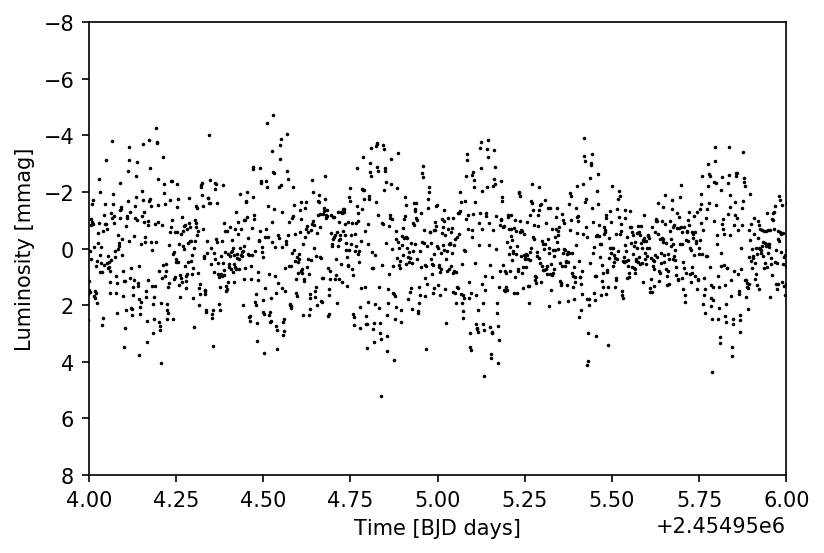

In [63]:
plt.scatter(times_TD, magnitudes_TD*1000, s=0.5, c='k')
#plt.xlim(min(times_TD), min(times_TD)+2)
plt.xlim(2454954, 2454954+2)
#plt.title('One day zoom')
#plt.xticks([min(times_TD)+1, min(times_TD)+3])
#plt.yticks([min(magnitudes_TD), 0, max(magnitudes_TD)])
#plt.xticks([])
#plt.yticks([])
plt.xlabel('Time [BJD days]')
plt.ylabel('Luminosity [mmag]')

plt.ylim(8, -8)

plt.savefig('lc2.png')

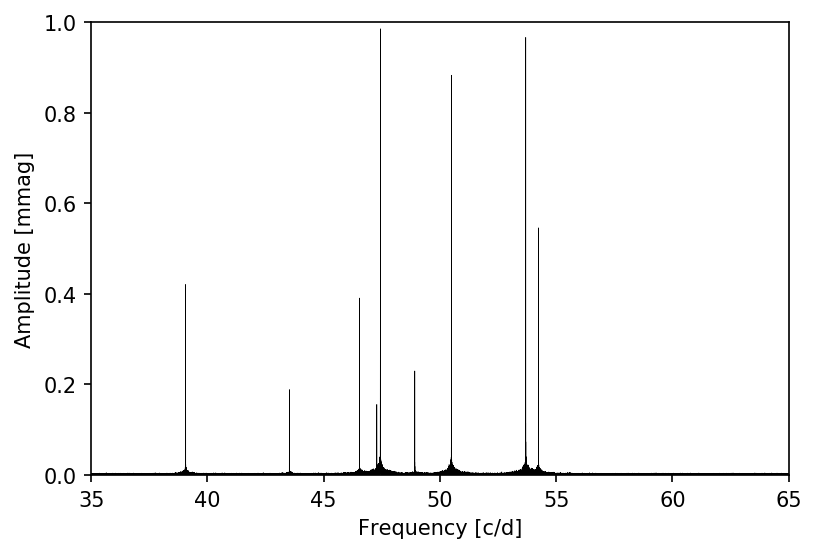

In [64]:
plt.plot(AS(times_TD, magnitudes_TD, 2)[0], AS(times_TD, magnitudes_TD, 2)[1]*1e3, lw=0.3, c='k')
plt.xlim(35, 65)
plt.ylim(0, 1)#max(AS(times_TD, magnitudes_TD, 2)[1])*1e6)
#plt.title('AS')
#plt.xticks([35, 60])
#plt.yticks([0, max(AS(times_TD, magnitudes_TD, 2)[1])*1e6])
#plt.xticks([])
#plt.yticks([])
plt.xlabel('Frequency [c/d]')
plt.ylabel('Amplitude [mmag]')

plt.savefig('as2.png')

DEFINE AS FUNTION
CALCULATE FREQS OF BETA PIC
IMPORT KEPLER TIMESTAMPS
61.17409022396696
778
CREATE MULTISINE MODEL
CALCULATE TIME DELAYS (MODEL)
CALCULATE TIME DELAYS (DATA)
DOWNLOAD JDs
CALCULATE WEIGHTED VALUES
PLOT EVERYTHING


/home/sebastian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


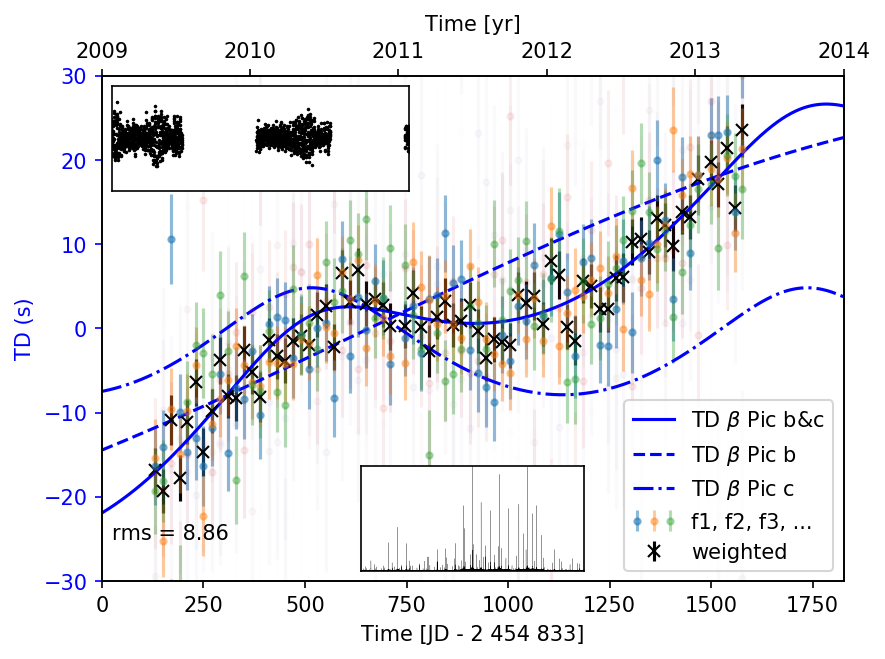

In [65]:
no_freqs_run = 9
no_freqs_run_weighted = 3
noise_TESS_mag_hour_ppm = 5*19.91
noise_hour_ppm = noise_TESS_mag_hour_ppm
segment_size = 20


# print('DOWNLOAD DATA')
# for name in ['beta Pictoris']:
#     sr = lk.search_lightcurvefile(name)
#     print(sr)

#     if len(sr) > 0:

#         #Download data
#         lcfs = sr.download_all()

#         # Use the normalized PDCSAP_FLUX
#         lc0 = lcfs[0].SAP_FLUX.normalize()
#         lc1 = lcfs[0].PDCSAP_FLUX.normalize()

#         # Loop through the rest of the LCFS, appending to the first light curve
#         for lcf in lcfs[1:]:
#             lc0 = lc0.append(lcf.SAP_FLUX.normalize())
#             lc1 = lc1.append(lcf.PDCSAP_FLUX.normalize())

#         #Remove bad quality and nans
#         q0 = lc0.quality == 0
#         lc0 = lc0[q0].remove_nans()
#         q1 = lc1.quality == 0
#         lc1 = lc1[q1].remove_nans()
#         #Plot data
#         ax = lc0.scatter(label = 'SAP_FLUX')
#         lc1.scatter(ax=ax, label = 'PDCSAP_FLUX')

        
#         #Times & Mags
#         times = lc1.time + 2457000
#         mags = -2.5 * np.log10(lc1.flux)
#         mags = mags - np.median(mags)
        
#         x = times
#         y = mags

        
print('DEFINE AS FUNTION')
#Amplitude Spectrum Function
def AS(times, flux, oversample):
    timebase = max(times) - min(times)
    tmin = min(times)
    tmax = max(times)
    df = 1.0 / (tmax - tmin)
    dt = np.median(np.diff(times))
    ny = 0.5 / dt
    oversample = oversample

    freq = np.arange(df, 120, df / oversample)
    model = LombScargle(times, flux)
    power = model.power(freq, method = 'fast', normalization = 'psd')
    fct = np.sqrt(4 / len(times))
    amp = np.sqrt(np.abs(power)) * fct
    
    return((freq, amp))


print('CALCULATE FREQS OF BETA PIC')

#AS
freq, amp = AS(times, mags, 15)
freq=freq[5000:]
amp=amp[5000:]

# PEAKS
max_power = amp.max()
peaks, _ = find_peaks(amp, height=max_power*0.02, distance=200)

# FREQS SORTED BY AMPLITUDE
sort_idx = np.argsort(amp[peaks])[::-1]
f_TESS = freq[peaks][sort_idx]
a_TESS = amp[peaks][sort_idx]
#print(len(f_TESS))



print('IMPORT KEPLER TIMESTAMPS')
import os
datadir = os.getcwd()
datafile = '/times_KIC.txt'

times_KIC_load = np.loadtxt(datadir+datafile, usecols=(0)).T
times_KIC = times_KIC_load


cadence_hour = 1/(np.median(np.diff(times_KIC))*24) # Measurements in 1 hour
print(cadence_hour)
noise_run = noise_hour_ppm * 1e-6 * np.sqrt(cadence_hour)
noise_run_ppm = int(noise_run*1e6)
print(noise_run_ppm)







#times_KIC = midvals(times_KIC)
times_KIC = times_KIC[times_KIC % 1 > 0.5]

print('CREATE MULTISINE MODEL')

#Phases
f_TESS = f_TESS[:no_freqs_run]
a_TESS = a_TESS[:no_freqs_run]
p_TESS = dft_phase(times, mags, f_TESS)/(2*np.pi)

model_times = lc_model_times(f_TESS, a_TESS, p_TESS*2*np.pi, times_KIC, noise_run)





print('CALCULATE TIME DELAYS (MODEL)')
#_b
star_planet_ratio_b = 1.8 / 11 * 1048
a2sini_b = 9.66 * np.sin(np.deg2rad(88.81))
e_b = 0.08
varpi_b = np.deg2rad(205.8)
Porb_b = 22.47*365.25
tp_b = 2455992

#_c
star_planet_ratio_c = 1.8 / 8.9 * 1048
a2sini_c = 2.7 * np.sin(np.deg2rad(88.81))
e_c = 0.24
varpi_c = np.deg2rad(-95)
Porb_c = 1220
tp_c = 2454117

y_tau_b = tau(times_KIC, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
#y_vrad_b = vrad(times_KIC, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c = tau(times_KIC, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
#y_vrad_c = vrad(times_KIC, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)



print('CALCULATE TIME DELAYS (DATA)')


times_TD = times_KIC - y_tau_b - y_tau_c
magnitudes_TD = model_times[4]



time_0 = times_TD[0]
time_slice, mag_slice, phase, phase_err = [], [], [], []
time_delays, time_delays_err, time_midpoints = [], [], []

t_edge = []

counter = 1
size=int((max(times_TD)-min(times_TD))//segment_size)

# Iterate over lightcurve
for t, y in zip(times_TD, magnitudes_TD):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if t - time_0 > segment_size:
        #print('{0}/{1}'.format(counter, size))
        # Append the time midpoint
        
        time_slice = np.array(time_slice)
        mag_slice = np.array(mag_slice)
        
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        
        phase_guess = dft_phase(time_slice, mag_slice, f_TESS)
        sol = fit_leastsq_my(time_slice, mag_slice, f_TESS, a_TESS, phase_guess/(2*np.pi))
        
        #print(phase_guess)
        phase.append(phase_guess)
        phase_err.append(sol[3]*2*np.pi)
        
        time_0 = t
        time_slice, mag_slice = [], []

        t_edge.append(t)
        
        counter += 1
        
phase = np.array(phase).T
phase_err = np.array(phase_err).T

# Phase wrapping patch
for ph, ph_err, f in zip(phase, phase_err, f_TESS):
    td = ph / (2*np.pi*f)
    time_delays.append(td-np.mean(td))
    time_delays_err.append(ph_err / (2*np.pi*f))
    


print('DOWNLOAD JDs')
jds = []
for i in np.arange(2009, 2015, 1):
    times_utc = ['{0}-01-01T12:00:00'.format(i)]
    t = Time(times_utc, format='isot', scale='utc')
    #print(t)
    #print(t.jd)
    jds.append(t.jd[0])



print('CALCULATE WEIGHTED VALUES')

time_delays_tmp = time_delays[:no_freqs_run_weighted]
time_delays_err_tmp = time_delays_err[:no_freqs_run_weighted]

td_weighted = []
td_weighted_err = []
for i in range(len(time_midpoints)):
    #print(i)
    tds, tds_err = [], []
    for j in range(len(time_delays_tmp)):
        #print(j)
        tds.append(time_delays_tmp[j][i])
        tds_err.append(time_delays_err_tmp[j][i])
    tds = np.array(tds)
    tds_err = np.array(tds_err)
    td_weighted.append(sum(tds/tds_err**2)/sum(1/tds_err**2))
    td_weighted_err.append((1/sum(1/tds_err**2))**(1/2))
td_weighted = np.array(td_weighted)
td_weighted_err = np.array(td_weighted_err)

print('PLOT EVERYTHING')
times_sim = np.linspace(jds[0], jds[-1], 1000)

y_tau_b_sim = tau(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
#y_vrad_b_sim = vrad(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim = tau(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
#y_vrad_c_sim = vrad(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

fig, ax1 = plt.subplots(1,1, figsize=(6, 4.5))

time_offset = 2454833

t_2009 = jds[0] - time_offset
t_2010 = jds[1] - time_offset
t_2011 = jds[2] - time_offset
t_2012 = jds[3] - time_offset
t_2013 = jds[4] - time_offset
t_2014 = jds[5] - time_offset


#ax1.set_xlim(jds[0] - time_offset, jds[-1] - time_offset)
lns11 = ax1.plot(times_sim - time_offset, (y_tau_b_sim + y_tau_c_sim) *86400, 'b', label = r"TD $\beta$ Pic b&c")
lns12 = ax1.plot(times_sim - time_offset, (y_tau_b_sim) *86400, 'b', ls = '--', label = r"TD $\beta$ Pic b")
lns13 = ax1.plot(times_sim - time_offset, (y_tau_c_sim) *86400, 'b', ls = '-.', label = r"TD $\beta$ Pic c")
ax1.set_xlabel('Time [JD - 2 454 833]')

ax1.set_ylabel('TD (s)', color='b')
ax1.tick_params('y', colors='b')
ax1.set_ylim(-30, 30)
ax1.set_xlim(t_2009, t_2014)

#ax2 = ax1.twinx()
# lns2 = ax2.plot(times_sim - time_offset, y_vrad_b + y_vrad_c, 'r', label = "RV curve")
# ax2.plot(times_sim - time_offset, y_vrad_b , 'r', label = "RV curve", ls = '--')
# ax2.plot(times_sim - time_offset, y_vrad_c, 'r', label = "RV curve", ls = '-.')
# ax2.set_ylabel('v$_{rad}$ (m/s)', color='r')
# ax2.tick_params('y', colors='r')

#lns = lns1+lns2
#labs = [l.get_label() for l in lns]


ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)

ax2.set_xticks([t_2009,t_2010,t_2011,t_2012,t_2013,t_2014])

#ax1.set_xlim(1070,1090)
#ax1.set_ylim(-120,70)

xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)
ax2.set_xticklabels(['2009', '2010', '2011', '2012', '2013', '2014'], fontsize=10)


ax2.set_xlabel('Time [yr]', labelpad=-200)
ax2.xaxis.set_label_coords(0.5,1.09)


#ax1.set_xlabel('BJD - 2457000.0 [d]')
#ax1.set_ylabel('magnitudes [mmag]')

#ttl = ax1.title
#ttl.set_position([.5, 1.05])

#ax1.set_title('bRing+BLb')


#lns3 = ax1.axvspan(min(times_KIC) - time_offset, max(times_KIC) - time_offset, alpha=0.5,  label='TESS')
# lns4 = ax1.axvspan(min(tB15_BJD) - time_offset, max(tB15_BJD) - time_offset, alpha=0.35, color='darkgreen', label='BRITE')
# ax1.axvspan(min(tB16_BJD) - time_offset, max(tB16_BJD) - time_offset, alpha=0.35, color='darkgreen')
# ax1.axvspan(min(tB17_BJD) - time_offset, max(tB17_BJD) - time_offset, alpha=0.35, color='darkgreen')
# lns5 = ax1.axvspan(min(t_bRing) - time_offset, max(t_bRing) - time_offset, alpha=0.5, color='k', label='bRing')
# lns6 = ax1.axvspan(min(t_ASTEP) - time_offset, 2458011.168025- time_offset, alpha=0.35, color='red', label='ASTEP')
# ax1.axvspan(2458206.1510377- time_offset, max(t_ASTEP) - time_offset, alpha=0.35, color='red')


y_tau_b_sim = tau(np.array(time_midpoints), star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim = tau(np.array(time_midpoints), star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
y_offset = np.median((y_tau_b_sim + y_tau_c_sim) *86400 - td_weighted*86400)
#ax1.scatter(np.array(time_midpoints) - time_offset, td_weighted*86400+y_offset, marker='x', c='k')   
lns2 = ax1.errorbar(np.array(time_midpoints) - time_offset, td_weighted*86400+y_offset, yerr = td_weighted_err*86400, fmt='.', marker='x', c='k', label = 'weighted')

leg_errbar = []
for i in range(no_freqs_run):
    #ax1.scatter(time_midpoints, time_delays[i]*86400, s=5)
    lns3 = ax1.errorbar(np.array(time_midpoints) - time_offset, time_delays[i]*86400+y_offset, yerr = time_delays_err[i]*86400, fmt='.', alpha = ((a_TESS[i]/a_TESS[0])**3)/2)
    ax1.set_ylim(-30, 30)
    leg_errbar.append(lns3)

from mpl_toolkits.axes_grid.inset_locator import inset_axes
inset_axes1 = inset_axes(ax1, 
                    width="40%", # width = 30% of parent_bbox
                    height=0.7, # height : 1 inch
                    loc=2)
plt.scatter(times_TD, magnitudes_TD, s=0.5, c='k')
plt.xlim(min(times_TD)+1, min(times_TD)+3)
#plt.title('One day zoom')
#plt.xticks([min(times_TD)+1, min(times_TD)+3])
#plt.yticks([min(magnitudes_TD), 0, max(magnitudes_TD)])
plt.xticks([])
plt.yticks([])

inset_axes2 = inset_axes(ax1, 
                    width="30%", # width = 30% of parent_bbox
                    height=0.7, # height : 1 inch
                    loc=8)
plt.plot(AS(times_TD, magnitudes_TD, 2)[0], AS(times_TD, magnitudes_TD, 2)[1]*1e6, lw=0.1, c='k')
plt.xlim(35, 60)
plt.ylim(0, max(AS(times_TD, magnitudes_TD, 2)[1])*1e6)
#plt.title('AS')
#plt.xticks([35, 60])
#plt.yticks([0, max(AS(times_TD, magnitudes_TD, 2)[1])*1e6])
plt.xticks([])
plt.yticks([])



# lns = [lns1[0], lns2[0], lns4, lns5, lns6, lns3]
# labs = [l.get_label() for l in lns]

#ax1.legend()
#ax1.legend(lns, labs, loc=4)

lns = [lns11[0], lns12[0], lns13[0], lns2]#lns2[0], lns4, lns5, lns6, lns3]
labs = [l.get_label() for l in lns]

#https://stackoverflow.com/questions/52038171/how-to-create-two-legend-objects-for-a-single-plot-instance/52040748#52040748
ax1.legend(handles = lns[:3]+[tuple(leg_errbar[:3])]+lns[3:], labels=labs[:3]+['f1, f2, f3, ...']+labs[3:],loc=4,
               handler_map = {tuple: matplotlib.legend_handler.HandlerTuple(None)})


# textstr = '\n'.join((
#     'rms b=%.1f' % (rms2(y_tau_b_sim*86400-(td_weighted*86400+y_offset)), ),
#     'rms b+c=%.1f' % (rms2((y_tau_b_sim+y_tau_c_sim)*86400- (td_weighted*86400+y_offset)), )))
# ax1.text(0.02, 0.1, textstr, transform=ax.transAxes, fontsize=8,
#         verticalalignment='top')

ax1.text(25, -25,'rms = {0:.2f}'.format(rms2(td_weighted*86400+y_offset)))
         
fig.tight_layout()
plt.show()

fig.savefig("TD_Kepler-Seg{0}-NoF{1}-NoFw{2}-Noisehr{3}-len{4}.png".format(segment_size, no_freqs_run, no_freqs_run_weighted, noise_hour_ppm, len(times_TD)), dpi=400)

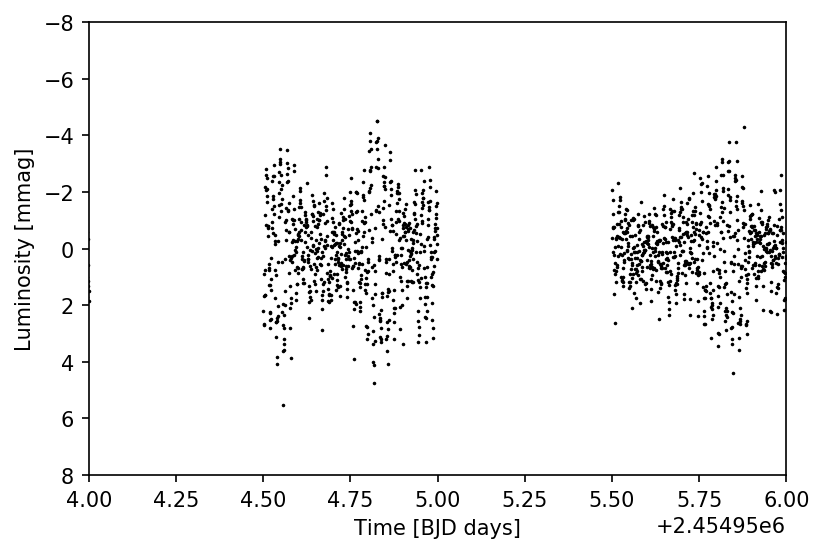

In [66]:
plt.scatter(times_TD, magnitudes_TD*1000, s=0.5, c='k')
#plt.xlim(min(times_TD), min(times_TD)+2)
plt.xlim(2454954, 2454954+2)
#plt.title('One day zoom')
#plt.xticks([min(times_TD)+1, min(times_TD)+3])
#plt.yticks([min(magnitudes_TD), 0, max(magnitudes_TD)])
#plt.xticks([])
#plt.yticks([])
plt.xlabel('Time [BJD days]')
plt.ylabel('Luminosity [mmag]')

plt.ylim(8, -8)

plt.savefig('lc3.png')

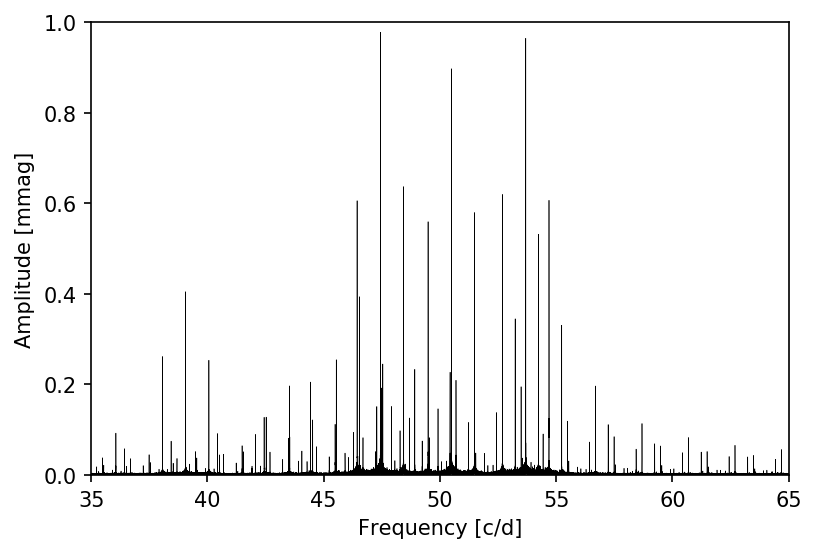

In [67]:
plt.plot(AS(times_TD, magnitudes_TD, 2)[0], AS(times_TD, magnitudes_TD, 2)[1]*1e3, lw=0.3, c='k')
plt.xlim(35, 65)
plt.ylim(0, 1)#max(AS(times_TD, magnitudes_TD, 2)[1])*1e6)
#plt.title('AS')
#plt.xticks([35, 60])
#plt.yticks([0, max(AS(times_TD, magnitudes_TD, 2)[1])*1e6])
#plt.xticks([])
#plt.yticks([])
plt.xlabel('Frequency [c/d]')
plt.ylabel('Amplitude [mmag]')

plt.savefig('as3.png')